# Intro Task, Object Localization 

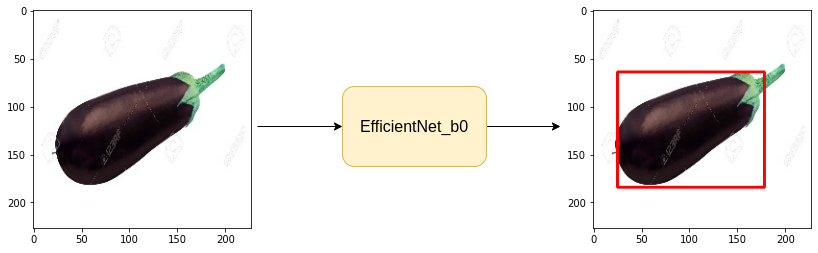

In [4]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-nigjbxcw
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-nigjbxcw
     |████████████████████████████████| 29.2 MB 1.6 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=2851996fbf59c99f5485184f95d82453facde397a8752a357e32d1fb1a0cfe11
  Stored in directory: /tmp/pip-ephem-wheel-cache-sxcxsw5w/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.2
    Uninstalling scikit-image-0.19.2:
      Successfully uninstalled scikit-image-0.19.2
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.0.3
    Uninstalling albumentations-1.0.3:
      Successfully uninstalled albumentations-1.0.3


In [ ]:
!pip install --force-reinstall albumentations==1.0.3

In [5]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 15.64 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [1]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Object Localization')

In [2]:
cd /content/drive/MyDrive/Object Localization

/content/drive/MyDrive/Object Localization


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Configurations

In [4]:
CSV_FILE = "/content/drive/MyDrive/Object Localization/object-localization-dataset/train.csv"
DATA_DIR = "/content/drive/MyDrive/Object Localization/object-localization-dataset/"

DEVICE = 'cuda'
BATCH_SIZE = 16
IMG_SIZE = 140
LR = .001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4


In [5]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


In [17]:
df.shape

(186, 8)

# Understand the dataset

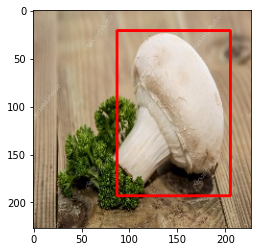

In [6]:
row = df.iloc[5]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img);

In [7]:
train_df, valid_df = train_test_split(df, test_size= .2, random_state= 42)

# Augmentations

In [8]:
import albumentations as A

In [10]:
train_augs = A.Compose([
                        A.Resize(IMG_SIZE, IMG_SIZE),
                        A.HorizontalFlip(p = .5),
                        A.VerticalFlip(p =.5),
                        A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields= ['class_labels']))

valid_augs = A.Compose([
                        A.Resize(IMG_SIZE, IMG_SIZE),
                      ], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields= ['class_labels']))

# Create Custom Dataset

In [11]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin

    xmax =  row.xmax
    ymax = row.ymax


    bbox = [[xmin, ymin, xmax, ymax]] #need to be in this format

    img_path = DATA_DIR + row.img_path

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 # from (h, w, c) to (c, h, w)
    bbox = torch.Tensor(bbox)

    return img, bbox










In [12]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)


In [14]:
print(f"Total examples in the training set: {len(trainset)}")
print(f"Total examples in the validation set: {len(validset)}")

Total examples in the training set: 148
Total examples in the validation set: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


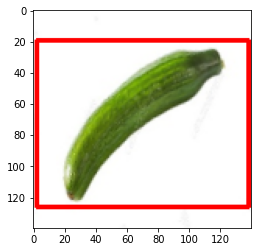

In [16]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img);

# Load dataset into batches

In [18]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader = torch.utils.data.DataLoader(validset, batch_size= BATCH_SIZE, shuffle= False)

In [19]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [20]:
for images, bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [21]:
from torch import nn 
import timm

In [22]:
class ObjLocModel(nn.Module):
  
  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained= True, num_classes = 4)


  def forward(self, images, gt_bboxes = None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    
    return bboxes
    





In [46]:
model = ObjLocModel()
model.to(DEVICE);

In [47]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [48]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0
  model.train()

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return  total_loss / len(dataloader)




In [49]:
def eval_fn(model, dataloader):
  total_loss = 0
  model.eval()

  with torch.no_grad():

    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)


      total_loss += loss.item()

  return  total_loss / len(dataloader)

#Training Loop

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [45]:
best_valid_loss= np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('WEIGHTS ARE SAVED!')
    best_valid_loss = valid_loss

  print(f"Epoch: {i +1} | train_loss: {train_loss} | validation_loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED!
Epoch: 1 | train_loss: 42.07057285308838 | validation_loss: 87.07165145874023


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED!
Epoch: 2 | train_loss: 41.323789024353026 | validation_loss: 54.572287241617836


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 42.50613441467285 | validation_loss: 83.15164693196614


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 41.2651008605957 | validation_loss: 80.29489390055339


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 40.92642326354981 | validation_loss: 83.22712071736653


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 40.22705574035645 | validation_loss: 69.78893280029297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 45.046123313903806 | validation_loss: 84.09509023030598


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 31.02172966003418 | validation_loss: 64.06516011555989


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED!
Epoch: 9 | train_loss: 31.699670791625977 | validation_loss: 47.26842816670736


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED!
Epoch: 10 | train_loss: 42.591248512268066 | validation_loss: 46.55553690592448


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 30.851148796081542 | validation_loss: 70.686097462972


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 29.016808128356935 | validation_loss: 47.27562713623047


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 34.79700126647949 | validation_loss: 65.19342422485352


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 30.989517211914062 | validation_loss: 86.62385559082031


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 35.21224880218506 | validation_loss: 61.84547678629557


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 24.892954063415527 | validation_loss: 63.06242116292318


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 41.3629186630249 | validation_loss: 72.1799685160319


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 33.92246837615967 | validation_loss: 72.30662282307942


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 40.10760288238525 | validation_loss: 56.18676312764486


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 34.575934410095215 | validation_loss: 89.31709988911946


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 | train_loss: 41.997304916381836 | validation_loss: 101.70948537190755


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 | train_loss: 41.355332946777345 | validation_loss: 77.10804621378581


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 | train_loss: 50.501399993896484 | validation_loss: 122.35973739624023


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 | train_loss: 33.90360717773437 | validation_loss: 66.20760345458984


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 | train_loss: 30.9046272277832 | validation_loss: 94.9972635904948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 | train_loss: 37.030931091308595 | validation_loss: 83.7732925415039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 | train_loss: 33.88219051361084 | validation_loss: 94.68615976969402


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 | train_loss: 32.84556941986084 | validation_loss: 72.2698148091634


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 | train_loss: 50.13191108703613 | validation_loss: 55.85946146647135


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 | train_loss: 29.47346725463867 | validation_loss: 70.10033798217773


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 | train_loss: 41.32214622497558 | validation_loss: 73.00032806396484


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 | train_loss: 34.70494632720947 | validation_loss: 67.3931058247884


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 | train_loss: 31.7155969619751 | validation_loss: 58.136374155680336


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 | train_loss: 27.93938055038452 | validation_loss: 79.24658838907878


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 | train_loss: 27.909128189086914 | validation_loss: 63.690948486328125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 | train_loss: 26.066105079650878 | validation_loss: 65.26809946695964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 | train_loss: 27.063980293273925 | validation_loss: 77.91627375284831


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 | train_loss: 30.94036159515381 | validation_loss: 58.961570739746094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 | train_loss: 46.26995067596435 | validation_loss: 60.48735427856445


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 | train_loss: 26.297411251068116 | validation_loss: 76.43694178263347


#Inference

In [57]:
import utils1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


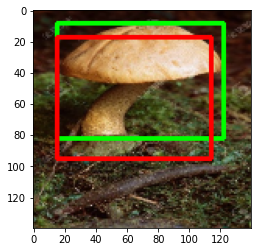

In [58]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image, bbox = validset[0] #(c, h, w)
  image = image.unsqueeze(0).to(DEVICE) # (bs, c, h, w)
  out_box = model(image)

  utils1.compare_plots(image, bbox, out_box);
